##### Image dataset: https://www.kaggle.com/datasets/hlrhegemony/pokemon-image-dataset?resource=download
##### Metainfo csv: https://github.com/lgreski/pokemonData/blob/master/Pokemon.csv
##### You can speed up model inference on colab by changing Hardware accelerator in runtime type to any GPU option

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install datasets transformers numpy pandas Pillow matplotlib
!pip install torch tqdm scipy
!pip install git+https://github.com/openai/CLIP.git
!pip install plotly umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-578poyri
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-578poyri
  Resolved https://github.com/openai/CLIP.git 

In [3]:
!pip install  opendatasets


In [14]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/hlrhegemony/pokemon-image-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: itamii
Your Kaggle Key: ··········


100%|██████████| 57.9M/57.9M [00:02<00:00, 28.7MB/s]


In [4]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import clip
import torch
from tqdm import tqdm
from scipy.special import softmax
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
from PIL import Image


In [5]:
%cd '/content/drive/MyDrive/219/Project2'

/content/drive/MyDrive/219/Project2


In [6]:
def construct_pokedex(csv_path='Pokemon.csv', image_dir='pokemon-image-dataset/images', type_to_load=None):
    pokedex = pd.read_csv(csv_path)
    image_paths = []

    for pokemon_name in pokedex["Name"]:
        imgs = glob(f"{image_dir}/{pokemon_name}/0.jpg")
        if len(imgs) > 0:
            image_paths.append(imgs[0])
        else:
            image_paths.append(None)

    pokedex["image_path"] = image_paths
    pokedex = pokedex[pokedex["image_path"].notna()].reset_index(drop=True)
    ids, id_counts = np.unique(pokedex["ID"], return_counts=True)
    ids, id_counts = np.array(ids), np.array(id_counts)
    keep_ids = ids[id_counts == 1]

    pokedex = pokedex[pokedex["ID"].isin(keep_ids)].reset_index(drop=True)
    pokedex["Type2"] = pokedex["Type2"].str.strip()
    if type_to_load is not None:
        pokedex = pokedex[pokedex["Type1"].isin(type_to_load)].reset_index(drop=True)
    return pokedex

def load_clip_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14", device=device)
    return model, preprocess, device

def clip_inference_image(model, preprocess, image_paths, device):
    image_embeddings = []
    with torch.no_grad():
        for img_path in tqdm(image_paths):
            img = Image.open(img_path)
            img_preprocessed = preprocess(img).unsqueeze(0).to(device)
            image_embedding = model.encode_image(img_preprocessed).detach().cpu().numpy()
            image_embeddings += [image_embedding]

    image_embeddings = np.concatenate(image_embeddings, axis=0)
    image_embeddings /= np.linalg.norm(image_embeddings, axis=-1, keepdims=True)
    return image_embeddings

def clip_inference_text(model, preprocess, texts, device):
    with torch.no_grad():
        text_embeddings = model.encode_text(clip.tokenize(texts).to(device)).detach().cpu().numpy()
    text_embeddings /= np.linalg.norm(text_embeddings, axis=-1, keepdims=True)
    return text_embeddings

def compute_similarity_text_to_image(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=-1)
    return similarity

def compute_similarity_image_to_text(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=0)
    return similarity

def umap_projection(image_embeddings, n_neighbors=15, min_dist=0.1, metric='cosine'):
    distance_matrix = np.zeros((image_embeddings.shape[0], image_embeddings.shape[0]))
    for i in range(image_embeddings.shape[0]):
        for j in range(image_embeddings.shape[0]):
            if i == j:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = np.dot(image_embeddings[i], image_embeddings[j])
    distance_matrix = 1 - distance_matrix
    reducer = TSNE(n_components=2, metric="precomputed", init="random", random_state=42)
    visualization_data = reducer.fit_transform(distance_matrix)
    return visualization_data

In [30]:
def get_top_relevant_pokemon(pokedex, model, preprocess, device, query, num_pokemon=5):
    # Inference CLIP model on text query
    text_embeddings = clip_inference_text(model, preprocess, [query], device)[0]
    image_paths = pokedex["image_path"].tolist()
    image_embeddings = clip_inference_image(model, preprocess, image_paths, device)
    similarity_scores = compute_similarity_text_to_image(image_embeddings, text_embeddings)
    top_indices = np.argsort(similarity_scores)[-num_pokemon:][::-1]
    relevant_pokemon = pokedex.loc[top_indices, ["Name", "Type1", "Type2","image_path"]]

    return relevant_pokemon

def plot_relevant_pokemon(relevant_pokemon, title):
    fig, axes = plt.subplots(1, len(relevant_pokemon), figsize=(15, 5))
    fig.suptitle(title)

    for i, (_, row) in enumerate(relevant_pokemon.iterrows()):
        ax = axes[i] if len(relevant_pokemon) > 1 else axes
        img_path = row["image_path"]
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"{row['Name']}\nType: {row['Type1']}{' / ' + row['Type2'] if pd.notna(row['Type2']) else ''}")

    plt.show()


100%|██████████| 753/753 [00:20<00:00, 36.90it/s]


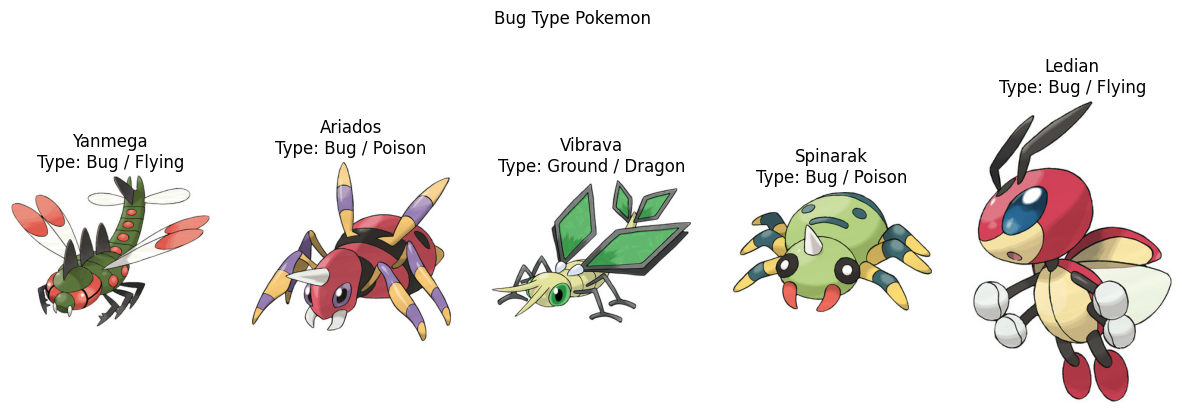

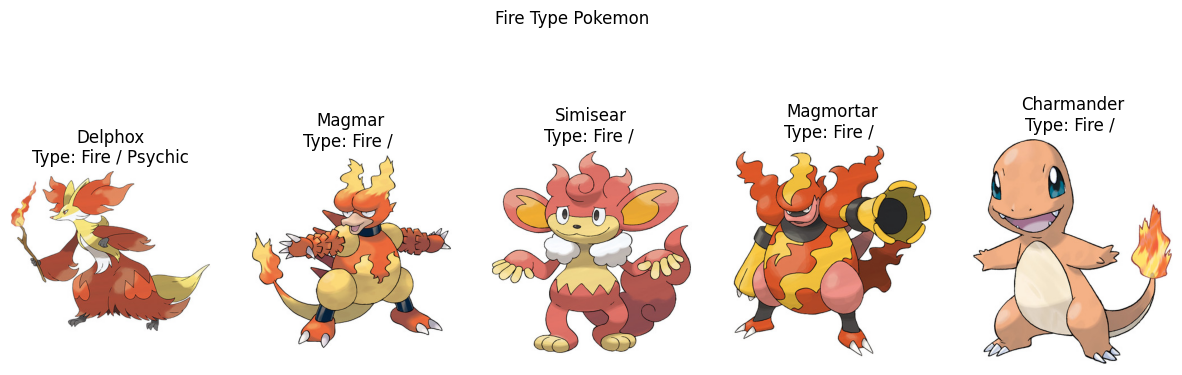

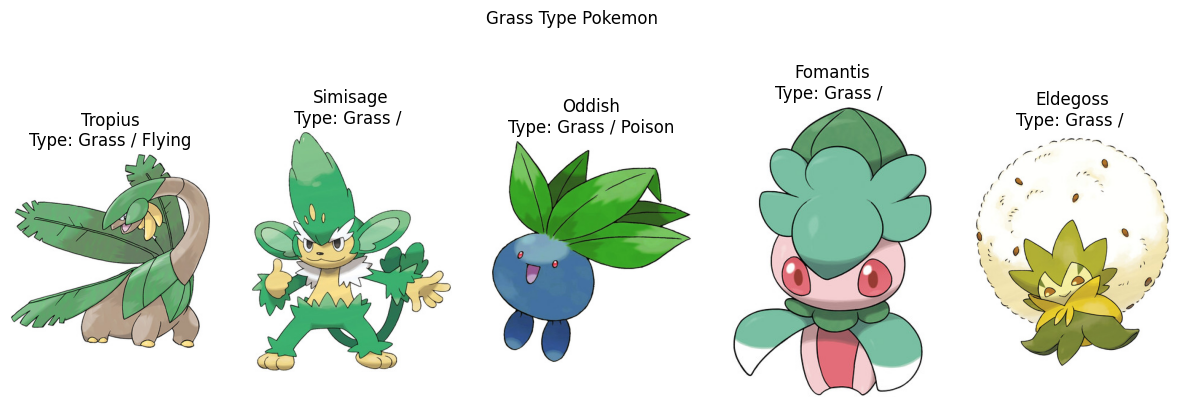

In [20]:
pokedex = construct_pokedex()
## Load CLIP model
model, preprocess, device = load_clip_model()

bug_query = "Pokemon type: Bug"
fire_query = "Pokemon type: Fire"
grass_query = "Pokemon type: Grass"

bug_relevant_pokemon = get_top_relevant_pokemon(pokedex, model, preprocess, device, bug_query, num_pokemon=5)
fire_relevant_pokemon = get_top_relevant_pokemon(pokedex, model, preprocess, device, fire_query, num_pokemon=5)
grass_relevant_pokemon = get_top_relevant_pokemon(pokedex, model, preprocess, device, grass_query, num_pokemon=5)

# Plot the relevant Pokemon
plot_relevant_pokemon(bug_relevant_pokemon, title="Bug Type Pokemon")
plot_relevant_pokemon(fire_relevant_pokemon, title="Fire Type Pokemon")
plot_relevant_pokemon(grass_relevant_pokemon, title="Grass Type Pokemon")


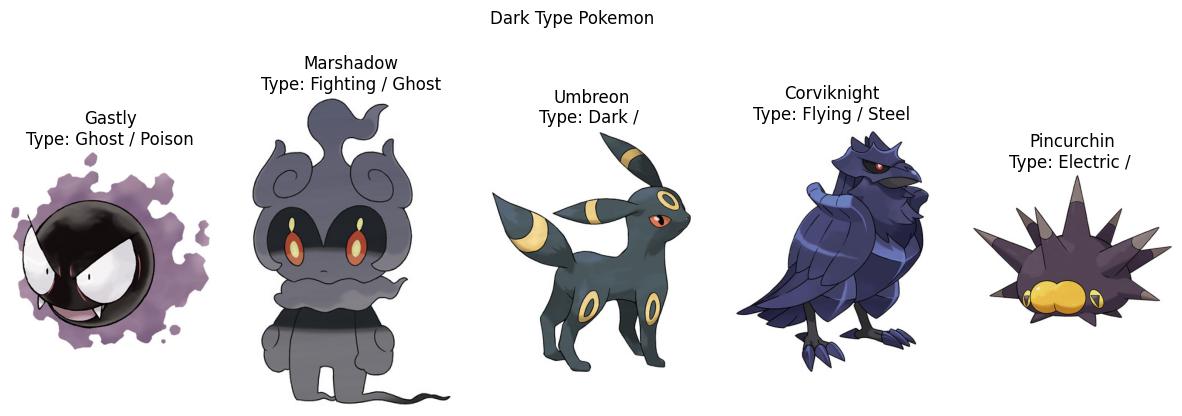

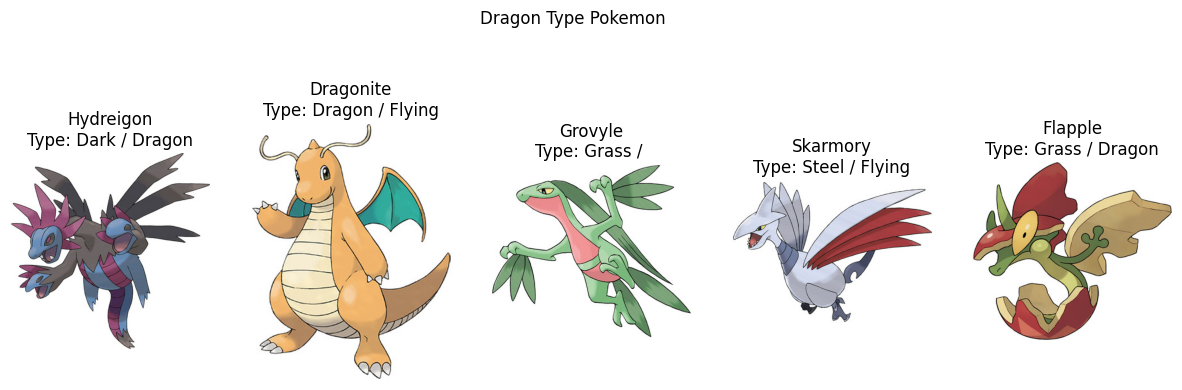

In [32]:
dark_query = "Pokemon type: Dark"
dragon_query = "Pokemon type: Dragon"

dark_relevant_pokemon = get_top_relevant_pokemon(pokedex, model, preprocess, device, dark_query, num_pokemon=5)
dragon_relevant_pokemon = get_top_relevant_pokemon(pokedex, model, preprocess, device, dragon_query, num_pokemon=5)

plot_relevant_pokemon(dark_relevant_pokemon, title="Dark Type Pokemon")
plot_relevant_pokemon(dragon_relevant_pokemon, title="Dragon Type Pokemon")


# ANSWER-26

We note that the queries function well for Bug, Fire and Grass pokemons (Error rates : 1/5, 0,0) respectively. For Dark type, it makes 4 errors out of 5 and for dragon it is 2 errors out of 5. We note that these errors arise due to overlap of certain features with other dragon types hence making the decision to pick a type more confusing. Dark for instance shares visual appearances similr to ghost and electric, and since CLIP looks at similarity between the text and the image, it could confuse one type for another if they visually have similar patterns. Take the dragon type for instance, "Grovyle" and "Skarmory" Pokemons in the image above look visually like dragons and hence get misclassified as Dragon types when in reality they are Grass and Steel types.


# Part-2

In [43]:
pokemon_types = pokedex["Type1"].unique()
formatted_types = [f"Pokemon type: {t}" for t in pokemon_types]

In [44]:
formatted_types

['Pokemon type: Grass',
 'Pokemon type: Fire',
 'Pokemon type: Water',
 'Pokemon type: Bug',
 'Pokemon type: Normal',
 'Pokemon type: Poison',
 'Pokemon type: Fairy',
 'Pokemon type: Fighting',
 'Pokemon type: Psychic',
 'Pokemon type: Electric',
 'Pokemon type: Ghost',
 'Pokemon type: Rock',
 'Pokemon type: Ground',
 'Pokemon type: Ice',
 'Pokemon type: Dragon',
 'Pokemon type: Dark',
 'Pokemon type: Steel',
 'Pokemon type: Flying']

# ANSWER-27

Images and top-5 types are as below in the cell output

100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


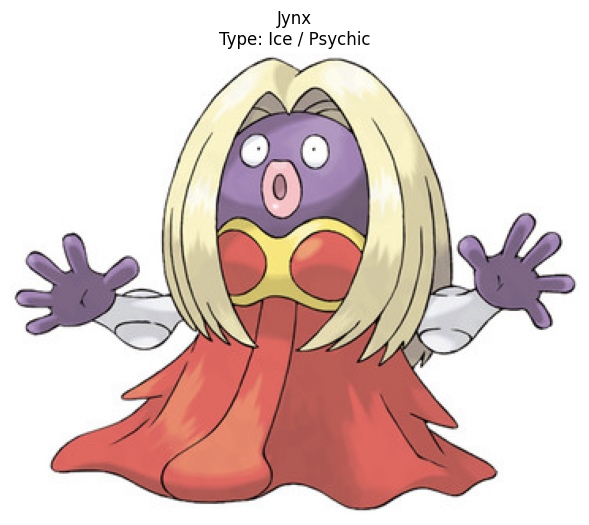

Top 5 Most Relevant Types:
  - Pokemon type: Psychic: Probability 0.66
  - Pokemon type: Dark: Probability 0.12
  - Pokemon type: Normal: Probability 0.09
  - Pokemon type: Rock: Probability 0.04
  - Pokemon type: Ghost: Probability 0.02




100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


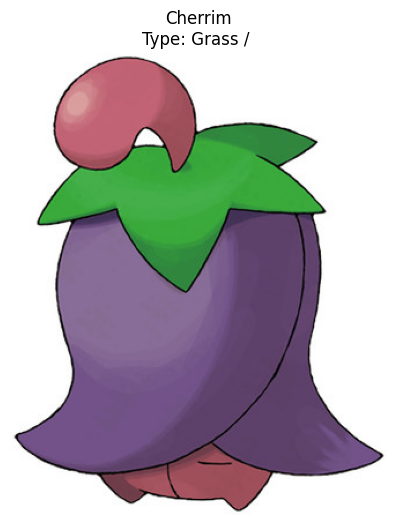

Top 5 Most Relevant Types:
  - Pokemon type: Poison: Probability 0.83
  - Pokemon type: Dark: Probability 0.07
  - Pokemon type: Psychic: Probability 0.03
  - Pokemon type: Normal: Probability 0.03
  - Pokemon type: Rock: Probability 0.01




100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


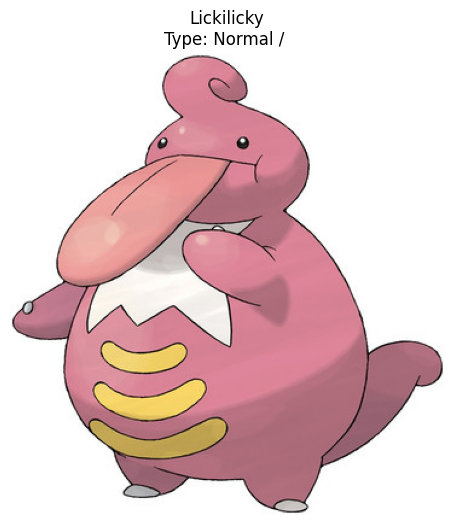

Top 5 Most Relevant Types:
  - Pokemon type: Normal: Probability 0.40
  - Pokemon type: Psychic: Probability 0.11
  - Pokemon type: Rock: Probability 0.11
  - Pokemon type: Electric: Probability 0.07
  - Pokemon type: Ice: Probability 0.06




100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


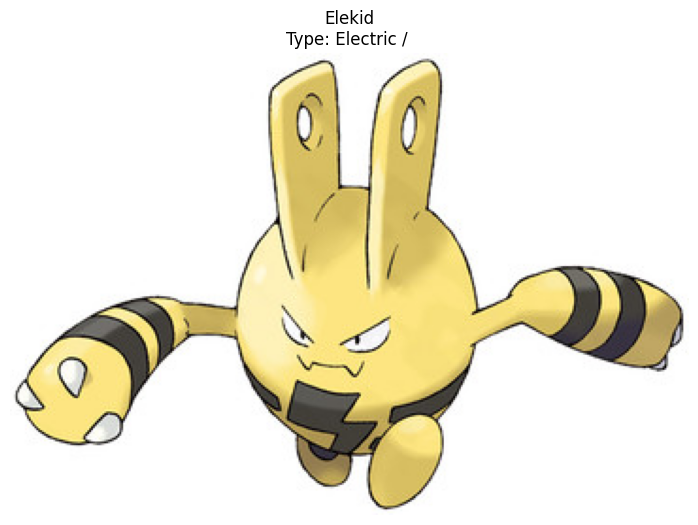

Top 5 Most Relevant Types:
  - Pokemon type: Electric: Probability 0.87
  - Pokemon type: Rock: Probability 0.05
  - Pokemon type: Ground: Probability 0.02
  - Pokemon type: Normal: Probability 0.01
  - Pokemon type: Psychic: Probability 0.01




100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


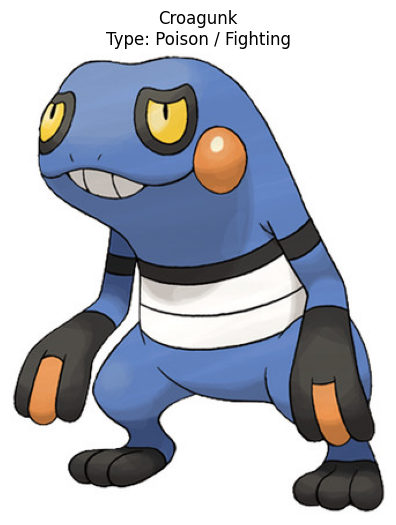

Top 5 Most Relevant Types:
  - Pokemon type: Normal: Probability 0.20
  - Pokemon type: Electric: Probability 0.18
  - Pokemon type: Dark: Probability 0.15
  - Pokemon type: Ground: Probability 0.10
  - Pokemon type: Rock: Probability 0.10




100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


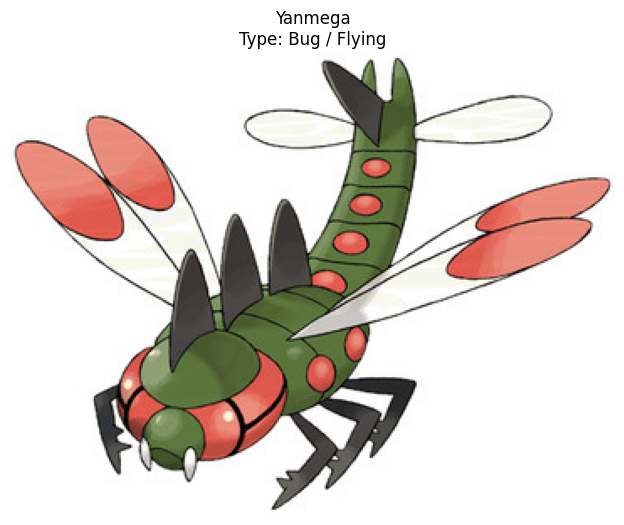

Top 5 Most Relevant Types:
  - Pokemon type: Bug: Probability 0.92
  - Pokemon type: Flying: Probability 0.04
  - Pokemon type: Normal: Probability 0.01
  - Pokemon type: Poison: Probability 0.01
  - Pokemon type: Rock: Probability 0.00




100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


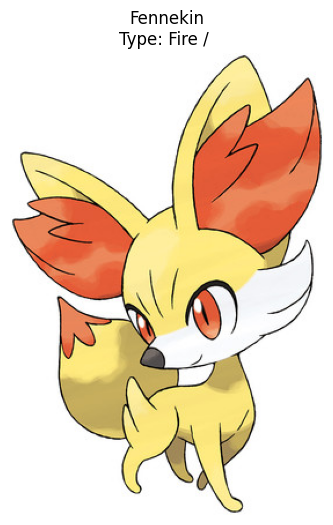

Top 5 Most Relevant Types:
  - Pokemon type: Fire: Probability 0.79
  - Pokemon type: Psychic: Probability 0.05
  - Pokemon type: Normal: Probability 0.04
  - Pokemon type: Electric: Probability 0.02
  - Pokemon type: Fairy: Probability 0.02




100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


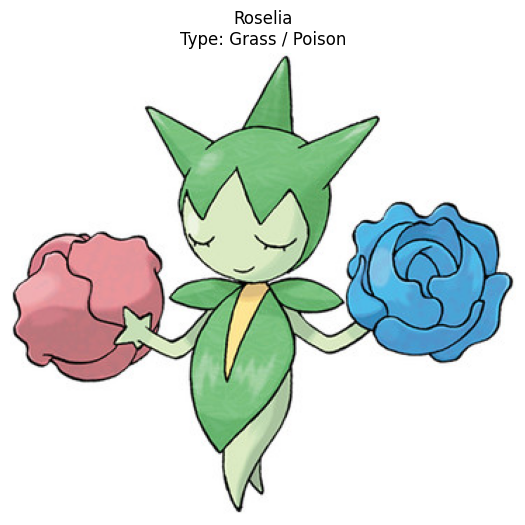

Top 5 Most Relevant Types:
  - Pokemon type: Fairy: Probability 0.83
  - Pokemon type: Poison: Probability 0.09
  - Pokemon type: Psychic: Probability 0.03
  - Pokemon type: Ice: Probability 0.01
  - Pokemon type: Electric: Probability 0.01




100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


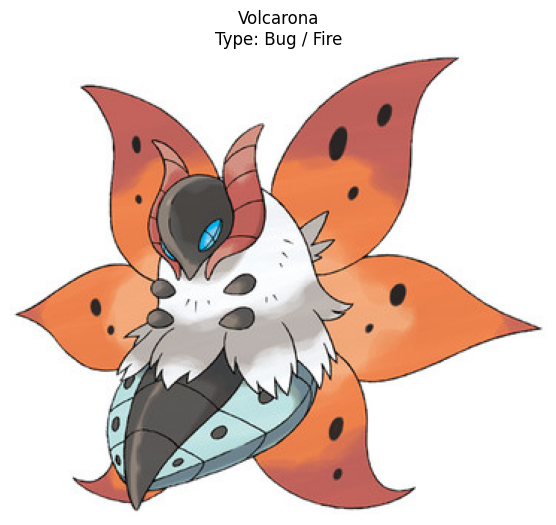

Top 5 Most Relevant Types:
  - Pokemon type: Bug: Probability 0.66
  - Pokemon type: Flying: Probability 0.07
  - Pokemon type: Dark: Probability 0.06
  - Pokemon type: Fairy: Probability 0.05
  - Pokemon type: Rock: Probability 0.05




100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


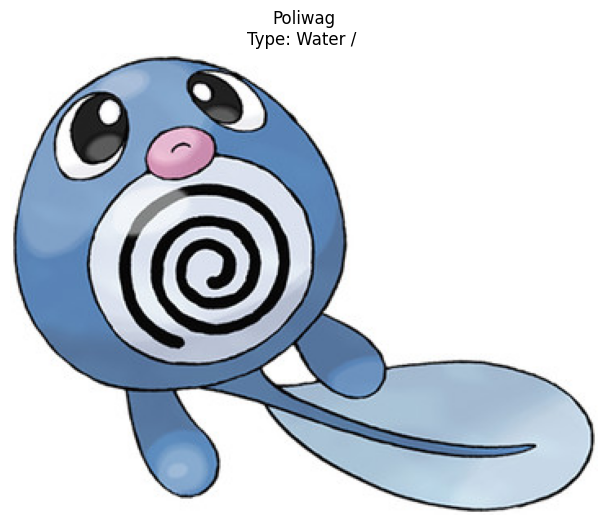

Top 5 Most Relevant Types:
  - Pokemon type: Water: Probability 0.90
  - Pokemon type: Psychic: Probability 0.04
  - Pokemon type: Ice: Probability 0.02
  - Pokemon type: Electric: Probability 0.01
  - Pokemon type: Normal: Probability 0.01




In [12]:
import random

def randomly_select_pokemon(pokedex, num_pokemon=10):
    selected_indices = random.sample(range(len(pokedex)), num_pokemon)
    selected_pokemon = pokedex.loc[selected_indices, ["Name", "Type1", "Type2", "image_path"]]
    return selected_pokemon

def get_most_relevant_types(pokemon, pokedex, model, preprocess, device):
    image_path = pokemon["image_path"]
    image_embeddings = clip_inference_image(model, preprocess, [image_path], device)
    all_types_init = pokedex["Type1"].unique()
    all_types = [f"Pokemon type: {t}" for t in all_types_init]
    all_types = np.array(all_types)
    all_types_embeddings = clip_inference_text(model, preprocess, all_types, device)
    similarity_scores = compute_similarity_text_to_image(image_embeddings, all_types_embeddings)
    similarity_scores_flat = similarity_scores.flatten()
    top_indices = np.argsort(similarity_scores_flat)[-5:][::-1]
    top_types = all_types[top_indices]
    top_probabilities = similarity_scores_flat[top_indices]

    return top_types.tolist(), top_probabilities.tolist()

def plot_selected_pokemon(selected_pokemon, pokedex, model, preprocess, device):
    for _, pokemon in selected_pokemon.iterrows():
        top_types, top_probabilities = get_most_relevant_types(pokemon, pokedex, model, preprocess, device)
        formatted_top_types = [f"Pokemon type: {t}" for t in top_types]
        plt.figure(figsize=(10, 6))
        plt.imshow(Image.open(pokemon["image_path"]))
        plt.title(f"{pokemon['Name']}\nType: {pokemon['Type1']}{' / ' + pokemon['Type2'] if pd.notna(pokemon['Type2']) else ''}")
        plt.axis("off")
        plt.show()

        print("Top 5 Most Relevant Types:")
        for t, p in zip(top_types, top_probabilities):
            print(f"  - {t}: Probability {p:.2f}")
        print("\n" + "="*50 + "\n")



selected_pokemon = randomly_select_pokemon(pokedex, num_pokemon=10)
plot_selected_pokemon(selected_pokemon, pokedex, model, preprocess, device)


# Part-3

In [28]:
selected_types = ["Bug", "Fire", "Grass"]
selected_data = pokedex[pokedex["Type1"].isin(selected_types)]
selected_image_paths = selected_data["image_path"].tolist()
selected_image_embeddings = clip_inference_image(model, preprocess, selected_image_paths, device)
visualization_data = umap_projection(selected_image_embeddings)

selected_data["tsne_x"] = visualization_data[:, 0]
selected_data["tsne_y"] = visualization_data[:, 1]
fig = px.scatter(
    selected_data,
    x='tsne_x',
    y='tsne_y',
    color='Type1',
    hover_name='Name',
    title='Clustering of Pokemon Types (Bug, Fire, Grass)',
)

fig.show()


<ipython-input-28-26fa331aafb6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data["tsne_x"] = visualization_data[:, 0]
<ipython-input-28-26fa331aafb6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data["tsne_y"] = visualization_data[:, 1]


# ANSWER-28
<img src="https://drive.google.com/uc?export=view&id=1tQmypodNL1zdfCZp_RP1FTtua1hLeQvn" width ="900">





When we use t-SNE to visualize how Pokemon images are grouped in a space, we  see some patterns related to their types like Bug in bottom left, Fire in bottom , and Grass in top right. It's like trying to see if Pokemon of the same type tend to stick together in clusters. However, because Pokemon types can be diverse and some may look similar, the groups might not be perfectly separated and have outliers. We can see some Pokemon of different types appearing close to each other. So, while it gives us a general idea, it might not capture all the complexities and variations in how Pokemon look. It's kind of like trying to group similar-looking Pokemon together, but there can be exceptions and overlap between different types.




